# Qualifications analysis for data jobs - scraped from karriere.at
#### TeamBanov
#### Henriett Kapui, Aleksandar Banov, Matthias Humer



Problem Overview:
Finding top skills for common roles in data science (Machine learning engineer, Data Scientist, Data Analyst, Data Engineer).

**This notebook** In this notebook we are going to conduct an analysis on the data we scraped from karriere.at on July 4th, 2022: It includes 1305 job advertisments in the field of data science, machine learning and co.

**Note:** This notebook looks very similar to _USA_jobs_analysis.ipynb_. Well, it is basically the same, we just used different data for this notebook.

### Read in the datasets in parts and do the preprocecssing steps

- **Load 2 CSV files.**
- First, we load the prepared csv file with the entries in German
- And also a csv file which contains the translation of the first data set

**Note:** In this notebook we do not use spark for the visualisations and analyses.

The data comes from karriere.at and was scraped by us ourselves. We were given permission to do this by the operator of the karriere.at platform by e-mail. The code for scraping can be found in a separate script file, along with the reason why we were not able to scrape in the Jupyter environment.

In [112]:
# imports
import pandas as pd
import numpy as np

# imports for plots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle,Circle
from matplotlib.lines import Line2D

# imports to do the regular expressions
from wordcloud import WordCloud
import regex as re
import nltk
from gensim.models import Word2Vec
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

# imports for the Choropleth map
import folium

In [113]:
# original version in German language

try:
    df_ger = pd.read_csv('AT_Jobs.csv', header=None)
# if the error occurs, handle it !!
except ImportError:
    print("An error occured while importing the file!!!")
    # if no error occurs
else:
    print("No Error occured!!")
    
df_ger.columns = ["city","company_name","crawl_timestamp","job_description","job_title","job_type","post_date"]

# translated version:
try:
    df = pd.read_csv('updated_translate.csv')
# if the error occurs, handle it !!
except ImportError:
    print("An error occured while importing the file!!!")
    # if no error occurs
else:
    print("No Error occured!!")
    
#df = pd.read_csv('updated_translate.csv')
df.head()

No Error occured!!
No Error occured!!


,Unnamed: 0,Unnamed: 0.1,city,company,craw_timestamp,job_description,job_title,type,post_data,test,en_description
0,0,0,Wien,Kaleido AI GmbH,2022-07-04 00:24:57,"(Senior) Data Analyst/Scientist;Vienna, Vienna...",(Senior) data analyst/scientist,Vollzeit,29.6.2022,"['(Senior) Data Analyst/Scientist;Vienna, Vien...","(Senior) Data Analyst/Scientist; Vienna, Vienn..."
1,1,1,Wien,svarmony Technologies GmbH,2022-07-04 00:25:00,"IT Systems Administrator (f/m/x);Hi, we are sv...",IT Systems Administrator (f/m/x),Vollzeit,29.6.2022,"[""IT Systems Administrator (f/m/x);Hi, we are ...","It Systems Administrator (f/m/x); Hi, we are s..."
2,2,2,Wien,Bundesrechenzentrum GmbH,2022-07-04 00:25:03,Beschreibung des BRZ;Das Bundesrechenzentrum (...,Data Science Consultant (W/M/D),Vollzeit,3.7.2022,['Beschreibung des BRZ;Das Bundesrechenzentrum...,Description of the BRZ; The Federal Rechenzent...
3,3,3,Wien,Greiner AG,2022-07-04 00:25:06,NEVEON. THE FUTURE OF FOAM.;NEVEON is a leadin...,Business Intelligence Analyst/Data Science Ent...,Vollzeit,2.7.2022,['NEVEON. THE FUTURE OF FOAM.;NEVEON is a lead...,Neveon. The Future of Foam .; NEVEON IS A Lead...
4,4,4,Wien,Raiffeisen Landesbank Niederösterreich Wien,2022-07-04 00:25:08,Sie wollen Aufbauarbeit in einem dynamischen A...,Internship in the Data Science area (W/M/D),Praktika,1.7.2022,['Sie wollen Aufbauarbeit in einem dynamischen...,Do you want to do construction work in a dynam...


In [114]:
# some cleaning of df; getting rid of not needed stuff
df = df.iloc[: , 1:]
df=df.drop(['test','job_description'], axis=1)
df.rename(columns = {'en_description':'job_description'}, inplace = True)
df.head()

,Unnamed: 0.1,city,company,craw_timestamp,job_title,type,post_data,job_description
0,0,Wien,Kaleido AI GmbH,2022-07-04 00:24:57,(Senior) data analyst/scientist,Vollzeit,29.6.2022,"(Senior) Data Analyst/Scientist; Vienna, Vienn..."
1,1,Wien,svarmony Technologies GmbH,2022-07-04 00:25:00,IT Systems Administrator (f/m/x),Vollzeit,29.6.2022,"It Systems Administrator (f/m/x); Hi, we are s..."
2,2,Wien,Bundesrechenzentrum GmbH,2022-07-04 00:25:03,Data Science Consultant (W/M/D),Vollzeit,3.7.2022,Description of the BRZ; The Federal Rechenzent...
3,3,Wien,Greiner AG,2022-07-04 00:25:06,Business Intelligence Analyst/Data Science Ent...,Vollzeit,2.7.2022,Neveon. The Future of Foam .; NEVEON IS A Lead...
4,4,Wien,Raiffeisen Landesbank Niederösterreich Wien,2022-07-04 00:25:08,Internship in the Data Science area (W/M/D),Praktika,1.7.2022,Do you want to do construction work in a dynam...


In [115]:
# some more cleaning; uses re library for regular expressions
def row_clean(row):
    row = str(row)                            # to string
    row = row.replace("-", " ")               # get's rid of hyphens 
    row = re.sub("[\n]", " ", row)            # get's rid of new lines
    row = re.sub("[.!?/\()-,:;•&]", "", row)  # get's rid of nonempty sequence of characters from the set of given characters (some are escaped)
    row = row.lower()                         # lowercases the data
    return row

df["clean_description"] = df["job_description"].apply(row_clean)

df["clean_description"].head()

0    senior data analystscientist vienna vienna aus...
1    it systems administrator fmx hi we are svarmon...
2    description of the brz the federal rechenzentr...
3    neveon the future of foam  neveon is a leading...
4    do you want to do construction work in a dynam...
Name: clean_description, dtype: object

### Level of education

First we would like to know what level of education is required for data jobs in general.

We are going to use word embeddings to get the level how many possition require the 3 main academic titles (Bachlors, Masters and PhDs). As we have discussed in the notebook with Spark NLP models a word embedding is an approach to provide a dense vector representation of words that capture something about their meaning. Word embeddings algorithms are key to the state-of-the-art results achieved by neural network models on natural language processing problems but here we aren't building anything like that!

In [116]:
# required download
nltk.download('punkt')

# 2 containters
sentences = []
sent_word_sets = []
for row in df.iterrows():                   # itterate through the rows
    desc = row[1].clean_description         # get second element of tuple which is the whole row and select the value of the clean_description column
    word_tokens = nltk.word_tokenize(desc)  # Return a tokenized copy the text
    sentences.append(word_tokens)           # saves the tokens into sentenses
    sent_word_sets.append(set(word_tokens)) # make a set of the tokens (no duplicates)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [117]:
# initialize the model 
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count= 1, workers=4)

In [118]:
# container
possible_words = set()

# Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
similar_words = model.wv.most_similar('bachelor', topn=30)

# itterate over similar words and add them if they are not already present in the set
for tup in similar_words:
    possible_words.add(tup[0]) 
similar_words

[('master', 0.9345830678939819),
 ('certificate', 0.9199425578117371),
 ('students', 0.8942164182662964),
 ('matura', 0.8721640706062317),
 ('degree', 0.8402343392372131),
 ('finished', 0.835477352142334),
 ('meng', 0.83078533411026),
 ('fh', 0.8294080495834351),
 ('bachelormaster', 0.8237164616584778),
 ('transcript', 0.8220923542976379),
 ('universityuniversity', 0.8219342231750488),
 ('economics', 0.8175657987594604),
 ('diploma', 0.816413938999176),
 ('thesis', 0.8155864477157593),
 ('fhuni', 0.8097909688949585),
 ('uni', 0.8036893010139465),
 ('educational', 0.8034659624099731),
 ('htl', 0.8027458786964417),
 ('studens', 0.7976128458976746),
 ('records', 0.7971000075340271),
 ('mathematicsstatistics', 0.796863317489624),
 ('physics', 0.7952000498771667),
 ('bsc', 0.7944117784500122),
 ('applied', 0.794297456741333),
 ('tufh', 0.7928740382194519),
 ('computer', 0.7910873889923096),
 ('phd', 0.7890006303787231),
 ('electrical', 0.7859938144683838),
 ('mathematics', 0.784810602664947

In [119]:
# Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
similar_words = model.wv.most_similar('masters', topn=30)

# itterate over similar words and add them if they are not already present in the set
for tup in similar_words:
    possible_words.add(tup[0])
similar_words

[('chemistry', 0.9322819113731384),
 ('uni', 0.9227837324142456),
 ('physics', 0.9145090579986572),
 ('blender', 0.9069432020187378),
 ('cf', 0.9058079123497009),
 ('bs', 0.9024635553359985),
 ('apparition', 0.8982089161872864),
 ('bioinformatics', 0.8980780839920044),
 ('resp', 0.8978336453437805),
 ('bsc', 0.8977608680725098),
 ('genomics', 0.8969746828079224),
 ('molecular', 0.8965486884117126),
 ('fhunihtl', 0.8959120512008667),
 ('360', 0.8954225182533264),
 ('generic', 0.8907978534698486),
 ('mint', 0.8897967338562012),
 ('graphics', 0.8877384066581726),
 ('biochemistry', 0.8869870901107788),
 ('dipl', 0.8837986588478088),
 ('mathematics', 0.883641242980957),
 ('feasability', 0.8832647204399109),
 ('cissp', 0.8816038966178894),
 ('pharmacology', 0.8813244700431824),
 ('fhtu', 0.8811700940132141),
 ('textile', 0.877842128276825),
 ('immunology', 0.8775008916854858),
 ('discipline', 0.87578284740448),
 ('school', 0.8755831122398376),
 ('screens', 0.8753230571746826),
 ('uraged', 0.

In [120]:
# Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
similar_words = model.wv.most_similar('phd', topn=30)

# itterate over similar words and add them if they are not already present in the set
for tup in similar_words:
    possible_words.add(tup[0])
similar_words

[('mathematics', 0.9397026896476746),
 ('economics', 0.9336285591125488),
 ('physics', 0.9308313727378845),
 ('discipline', 0.9250354766845703),
 ('equivalent', 0.9248594045639038),
 ('informatics', 0.9161430597305298),
 ('biochemistry', 0.9154859781265259),
 ('biology', 0.9137414693832397),
 ('similar', 0.907869279384613),
 ('comparable', 0.9043127298355103),
 ('chemistry', 0.9032702445983887),
 ('preferably', 0.9023884534835815),
 ('statistics', 0.8968469500541687),
 ('mathematicsstatistics', 0.8915586471557617),
 ('iinformatics', 0.8892543911933899),
 ('htl', 0.8824335336685181),
 ('hak', 0.8790717720985413),
 ('certification', 0.8783644437789917),
 ('study', 0.8769176602363586),
 ('fhuni', 0.8764570951461792),
 ('fh', 0.875106155872345),
 ('360', 0.8736181259155273),
 ('computer', 0.8730673789978027),
 ('mathematic', 0.8717705011367798),
 ('sciencesoftware', 0.8712030053138733),
 ('masters', 0.8701941967010498),
 ('socialsciences', 0.868216335773468),
 ('uni', 0.8681686520576477),


In [121]:
print(possible_words)

{'cf', 'comparable', 'fh', 'diploma', 'computer', 'bioinformatics', 'bs', 'matura', 'certificate', 'immunology', 'biotechnology', 'bsc', 'blender', 'pharmacology', 'certification', 'meng', 'graphics', '360', 'finished', 'uni', 'equivalent', 'htl', 'socialsciences', 'educational', 'phd', 'informatics', 'chemistry', 'sciencesoftware', 'applied', 'universityuniversity', 'screens', 'fhtu', 'degree', 'fhunihtl', 'generic', 'thesis', 'uraged', 'molecular', 'school', 'study', 'masters', 'transcript', 'mathematics', 'dipl', 'master', 'tufh', 'genomics', 'mint', 'hak', 'economics', 'textile', 'feasability', 'cissp', 'discipline', 'biology', 'statistics', 'mathematic', 'studens', 'preferably', 'biochemistry', 'fhuni', 'iinformatics', 'electrical', 'apparition', 'bachelormaster', 'similar', 'students', 'records', 'mathematicsstatistics', 'resp', 'physics'}


After taking a look at the output of the **Word2Vec.most_similar** we get a sense how are the different academic titles (Bachlors, Masters and PhDs) written down in the job description.

Now we just make lists with the most common appearing strings that describe the titles we are interested in.

In [122]:
bachelor_list = ['bs','b.s','bsc','bs/ms','bachelor','ba/bs','b.s.','bs/ms/phd','bachelors','ba','bs/ba','undergraduate']
master_list = ['masters','master','bs/ms','m.s.','m.s','msc','bs/ms/phd','ms','md/phd','ms/phd','postgraduate']
phd_list = ['phd','ph.d.','ph.d','bs/ms/phd','md/phd','ms/phd','doctoral','postgraduate','doctorate']

In [123]:
# make a column out of the set of the tokens
df["sent_word_sets"] = sent_word_sets

In [124]:
def has_qual(word_set,qual_list):
    for word in qual_list:   # for each possible word that describes the academic title
        if word in word_set: # check if it matches words from the description
            return True
    return False

In [125]:
# apply to the new column to creat 3 new binary columns that describe the academic title of the job
df["bachelors"] = df["sent_word_sets"].apply(lambda x: has_qual(x,bachelor_list))
df["masters"] = df["sent_word_sets"].apply(lambda x: has_qual(x,master_list))
df["phd"] = df["sent_word_sets"].apply(lambda x: has_qual(x,phd_list))

In [126]:
print(f"Bachelor jobs: {df['bachelors'].sum()}")
print(f"Masters jobs: {df['masters'].sum()}")
print(f"PhD of jobs: {df['phd'].sum()}")

Bachelor jobs: 205
Masters jobs: 465
PhD of jobs: 76


Bulding a nice **donut plot** to vizualize our results:

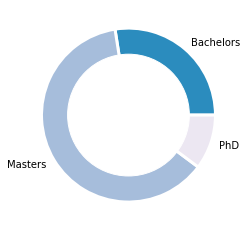

In [127]:
# library
import matplotlib.pyplot as plt
 
# create data
names = ['Bachelors', 'Masters', 'PhD']
size = [df['bachelors'].sum(),df['masters'].sum(),df['phd'].sum()]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.pie(size, labels=names, colors=['#2b8cbe','#a6bddb','#ece7f2'], wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

### Skill Analysis

We can utilize regular expressions to search for a specific programming language, technology, etc.

In [128]:
# convert the column to an array of stirngs
text = df.clean_description.values

In [129]:
# Create a regex search function
def count_text(patt,text):
    pattern = re.compile(patt) # regex pattern to regex object used for matching
    count = 0                  # counter
    for t in text:             # itterate over the strings of all columns
        if pattern.search(t):  # if we find a match for the regex pattern
            count+=1           # we add to the counter
    return count

**Programming skills**

In [130]:
# Create a data frame with skills name and regex pattern to search with
skills = ['Python','Hadoop','SQL','Tableau','TensorFlow','Agile','Power BI','SSaS','Algorithm','Java','Visualization']

skill_patt = ['(?i)\WPython\W','(?i)\WHadoop\W?','(?i)SQL\w*','(?i)\WTableau\W?',
              "(?i)\WTensorFlow\W?","(?i)\WAgile\W?","(?i)\WPower\s?BI\W?",
             "(?i)\WSSAS\W?","(?i)\WAlgorithms?\W?",'(?i)Java\w*','(?i)\WVisualization\W?']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [131]:
#container
container = []

# Iterate through the list of skill using the search function created
for x in skill_df['regex_pattern']:
    # append the number of counts to the container
    container.append(count_text(x,text))
    
# assign the container to a column    
skill_df['count'] = container

#calculate the percentage
skill_df['percentage'] = round(skill_df['count']/len(text),2)
skill_df

,skill,regex_pattern,count,percentage
0,Python,(?i)\WPython\W,418,0.32
1,Hadoop,(?i)\WHadoop\W?,26,0.02
2,SQL,(?i)SQL\w*,407,0.31
3,Tableau,(?i)\WTableau\W?,77,0.06
4,TensorFlow,(?i)\WTensorFlow\W?,28,0.02
5,Agile,(?i)\WAgile\W?,373,0.29
6,Power BI,(?i)\WPower\s?BI\W?,119,0.09
7,SSaS,(?i)\WSSAS\W?,3,0.00
8,Algorithm,(?i)\WAlgorithms?\W?,75,0.06
9,Java,(?i)Java\w*,181,0.14


C:\Users\Asus\AppData\Local\Temp/ipykernel_12824/1080612751.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


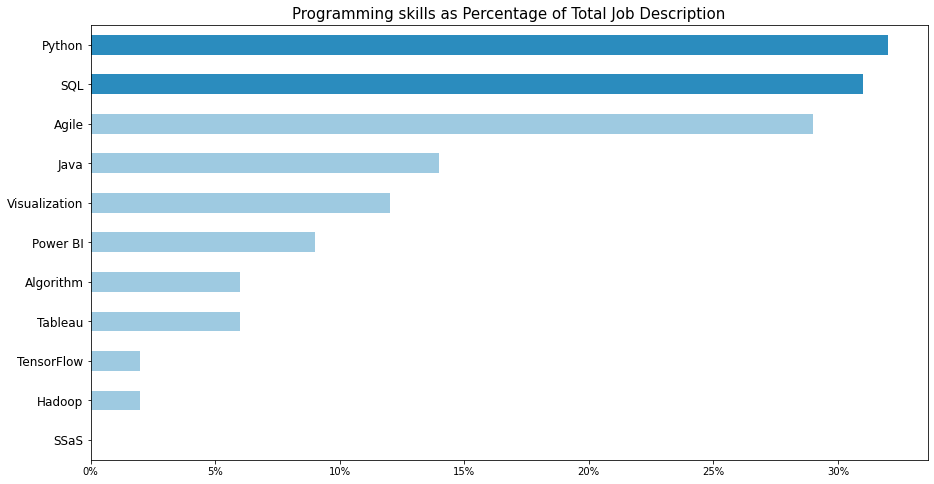

In [132]:
x = skill_df.sort_values(by = 'percentage')

ax =x['percentage'].plot(kind = "barh",figsize = (15,8),\
                         color=['#9ecae1','#9ecae1','#9ecae1','#9ecae1',\
                                '#9ecae1','#9ecae1','#9ecae1','#9ecae1','#9ecae1','#2b8cbe', '#2b8cbe'])

ax.set_title('Programming skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])

plt.show()

**Cloud Service Providers**

In [133]:
# Create a data frame with skills name and regex pattern to search with
skills = ['AWS','Azure','GCP']

skill_patt = ['(?i)AWS\w*','(?i)\WAzure\W?','(?i)GCP\w*']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [134]:
# container
container = []

# Iterate through the list of skill using the search function created
for x in skill_df['regex_pattern']:
    container.append(count_text(x,text))

# assign the container to a column
skill_df['count'] = container

# calculate the percentage
skill_df['percentage'] = round(skill_df['count']/len(text),2)
skill_df

,skill,regex_pattern,count,percentage
0,AWS,(?i)AWS\w*,109,0.08
1,Azure,(?i)\WAzure\W?,141,0.11
2,GCP,(?i)GCP\w*,33,0.03


C:\Users\Asus\AppData\Local\Temp/ipykernel_12824/1476302096.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


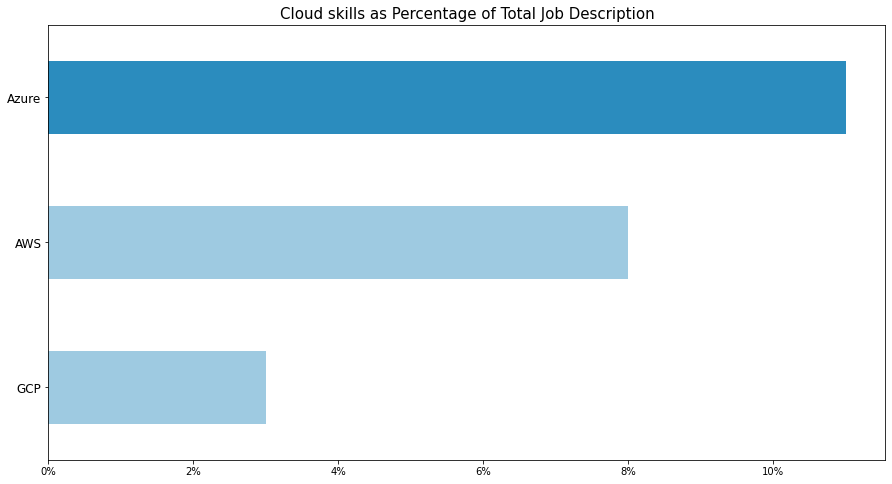

In [135]:
x = skill_df.sort_values(by = 'percentage')

ax =x['percentage'].plot(kind = "barh",figsize = (15,8), color=['#9ecae1','#9ecae1','#2b8cbe'])

ax.set_title('Cloud skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
plt.show()


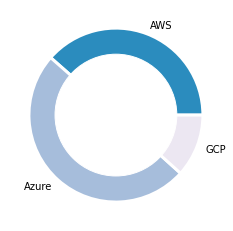

In [136]:
# library
import matplotlib.pyplot as plt
 
# create data
names = ['AWS', 'Azure', 'GCP']
size = skill_df['count'].values.tolist()
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
plt.pie(size, labels=names, colors=['#2b8cbe','#a6bddb','#ece7f2'], wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

**Technologies**

In [137]:
# Create a data frame with skills name and regex pattern to search with
skills = ['tensorflow','pytorch','spark','keras','opencv','cuda','pandas','matplotlib','tidyverse']

skill_patt = ["(?i)\WTensorFlow\W?","(?i)\WPyTorch\W?","(?i)\WSpark\W?","(?i)\Wkeras\W?","(?i)\Wopencv\W?","(?i)\WCuda\W?",'(?i)\WPandas\W?','(?i)\Wmatplotlib\W?','(?i)Wtidyverse\W?']

skill_df =pd.DataFrame(
    {"skill": skills,
     "regex_pattern":skill_patt})

In [138]:
# container
container = []

# Iterate through the list of skill using the search function created
for x in skill_df['regex_pattern']:
    container.append(count_text(x,text))
    
# assign the container to a column
skill_df['count'] = container

# calculate the percentage
skill_df['percentage'] = round(skill_df['count']/len(text),2)

skill_df


,skill,regex_pattern,count,percentage
0,tensorflow,(?i)\WTensorFlow\W?,28,0.02
1,pytorch,(?i)\WPyTorch\W?,14,0.01
2,spark,(?i)\WSpark\W?,84,0.06
3,keras,(?i)\Wkeras\W?,20,0.02
4,opencv,(?i)\Wopencv\W?,1,0.00
5,cuda,(?i)\WCuda\W?,0,0.00
6,pandas,(?i)\WPandas\W?,23,0.02
7,matplotlib,(?i)\Wmatplotlib\W?,5,0.00
8,tidyverse,(?i)Wtidyverse\W?,0,0.00


C:\Users\Asus\AppData\Local\Temp/ipykernel_12824/3952455690.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


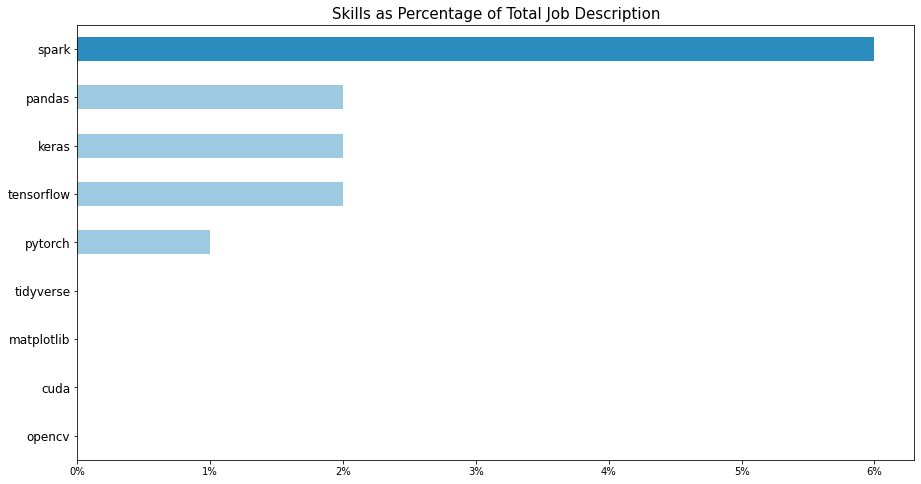

In [139]:
x = skill_df.sort_values(by = 'percentage')

ax =x['percentage'].plot(kind = "barh",figsize = (15,8),\
                         color=['#9ecae1','#9ecae1','#9ecae1','#9ecae1',\
                                '#9ecae1','#9ecae1','#9ecae1','#9ecae1','#2b8cbe'])


ax.set_title('Skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 12)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])

plt.show()

### Folium Map

In this part we show the distribution of job advertisements in the different municipalities and cities in Austria and we clearly see that in Austria the capital Vienna has the most to offer.

For the map we can use the original (in German language) dataset.

In [140]:
# create a list with all cities and clean it
cities = df_ger['city']
cities = [element for item in cities for element in item.split(',')] # some postings had 2 or more cities mentioned. With this line we include them all
cities = [element.replace('Vienna', 'Wien') for element in cities]
cities = [element.replace('Wien 3', 'Wien') for element in cities]
cities = [element.replace('Wien 10. Bezirk (Favoriten)', 'Wien') for element in cities]
cities = [element.replace('Wien 12', 'Wien') for element in cities]
cities = [element.replace('Wien 19', 'Wien') for element in cities]
cities = [element.replace('Wien 22', 'Wien') for element in cities]
cities = [element.replace('1020 Wien', 'Wien') for element in cities]
cities = [element.replace('1090 Wien', 'Wien') for element in cities]
cities = [element.replace('1120 Wien', 'Wien') for element in cities]
cities = [element.replace('1220 Wien', 'Wien') for element in cities]
# a better alternative (for future projects) would be to drop all numbers in the string instead of replacing all cases one by one. but in this case we already reached our goal with the more complicated way...
cities = [element.replace('(Stadt)', '') for element in cities]
cities = [element.replace('(Bezirk)', '') for element in cities]
cities = [element.replace('-Umgebung', '') for element in cities]
cities = [element.strip(' ') for element in cities]
#print(cities)

In [141]:
# converting the list of cities into a dict with the count of each city
counts = dict()
for i in cities:
    counts[i] = counts.get(i, 0) + 1

# converting the dict into a df
census = pd.DataFrame(counts.items())

In [142]:
# get a geo json file and match the the feature.properties.name key to the city names of the census df
url = "https://raw.githubusercontent.com/ginseng666/GeoJSON-TopoJSON-Austria/master/2021/simplified-99.9/gemeinden_999_geo.json"

maps = folium.Map(location=[47.5, 13.5], zoom_start=7)

folium.Choropleth(
    geo_data= url,
    name="choropleth",
    data=census,
    columns=[0,1],
    key_on="feature.properties.name",
    fill_color="PuOr",  # Spectral, RdBu, PuOr, YlOrRd, Greens
    fill_opacity=.9,
    line_opacity=0.2,
    bins=11,  # 9
    legend_name="job offers",
    #nan_fill_color="red",
    #nan_fill_opacity=.7,
    nan_fill_opacity=0,
).add_to(maps)

folium.LayerControl().add_to(maps)
maps